## Main code to process video clip
+ Parse each frame of the video and pass it to CLIP to gather object probabilities corresponding to each frame 
+ Use OpenCV to generate a time-varying bar chart and place it on top of the video clip

[{'railway track': 25.3, 'pedestrian': 8.1, 'dog': 66.7}]


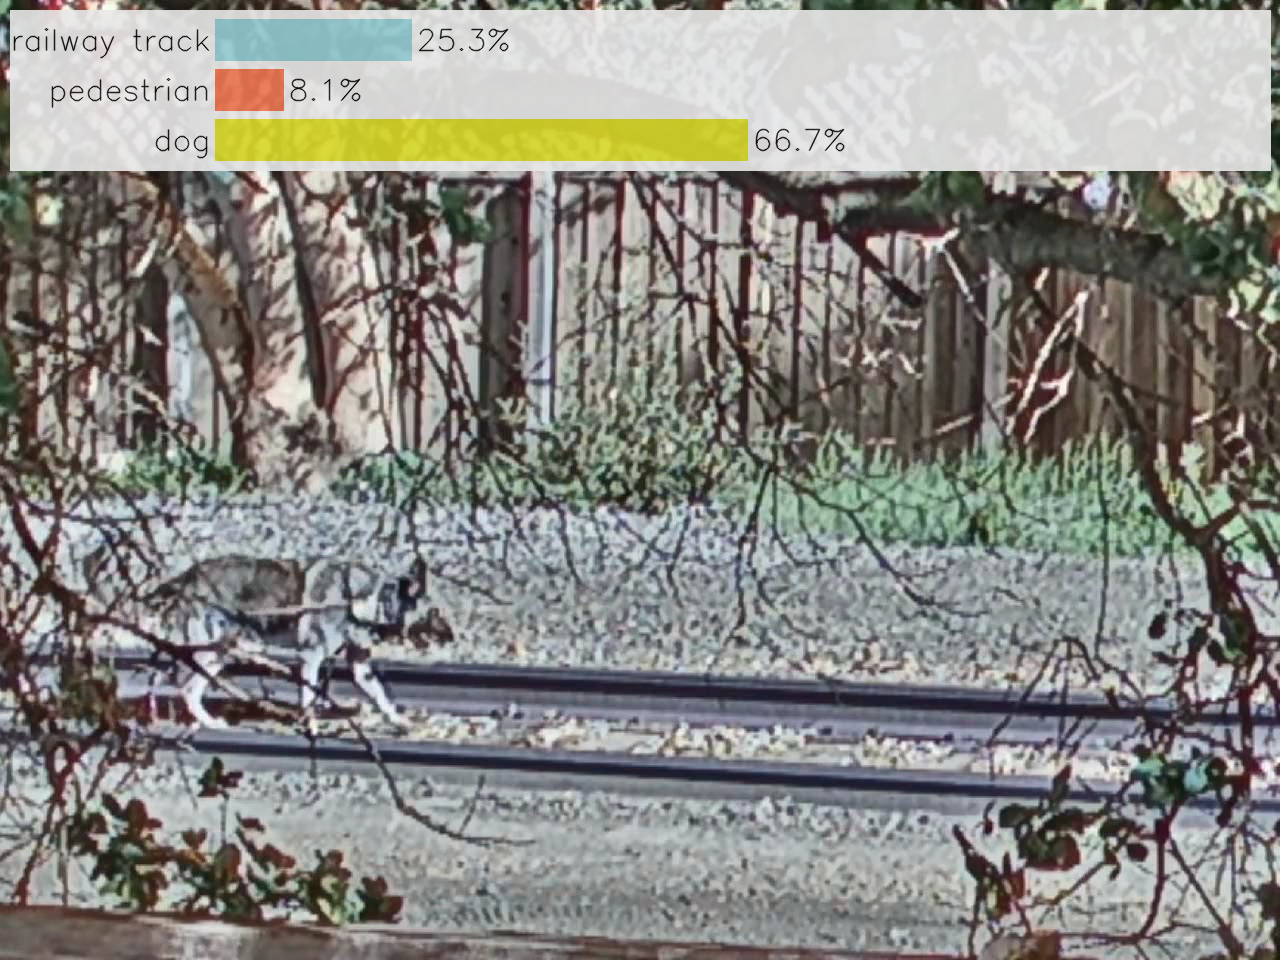

In [4]:
import torch
import clip
from PIL import Image
import time
import numpy as np
import time
import cv2

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# define objects of interst
fixed_objects = ['railway track']
moving_objects = ['pedestrian', 'dog']

objects = fixed_objects + moving_objects

# precompute tokenized text
tokenized_text = clip.tokenize(objects).to(device)
        
# init video stream
vcap = cv2.VideoCapture('/Users/prajan/projects/clip-1/media/input_fps_10.mp4')

fps = vcap.get(cv2.CAP_PROP_FPS)
width = int(vcap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(vcap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# init output clip 
clip_location = '/Users/prajan/projects/clip-1/media/output_fps_10.mp4'
fourcc = cv2.VideoWriter_fourcc('X', 'V', 'I', 'D')
out = cv2.VideoWriter(clip_location, fourcc, 5, (width, height))

cnt = 0
p_dog = []
p_pedestrian = []
p_railway = []
print_flag =True

# process each frame
ret, frame = vcap.read()
while ret:
    
    ret, curr_frame = vcap.read()

    if ret is False:
        out.release()
        break
   
    offsets = []
    detected_object, detected_object_frame_indx, frame_probs = CLIP_classifier([curr_frame], offsets, fixed_objects, moving_objects, tokenized_text)
    
    # accumulate probabilities
    p_dog.append(frame_probs[0]['dog'])
    p_pedestrian.append(frame_probs[0]['pedestrian'])
    p_railway.append(frame_probs[0]['railway track'])

    __draw_bar(curr_frame, frame_probs[0], (width, height), (0,0,139))

    out.write(curr_frame)

    # print once only for sanity check
    if print_flag and frame_probs[0]['dog'] > frame_probs[0]['railway track']:
        print(frame_probs)
        display(Image.fromarray(curr_frame))
        print_flag = False

    frame = curr_frame

out.release()

+ Generate Matlab plot of probabilities vs time

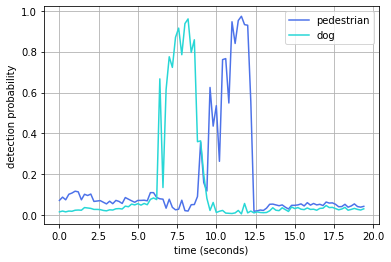

In [5]:
import matplotlib.pyplot as plt
import numpy as np

bg_colors = [(146,202,209), (233,114,77), (214,215,39)]

xpoints = np.array(list(range(len(p_pedestrian))))/5

ypoints = np.array(p_pedestrian)/100
plt.plot(xpoints, ypoints, label = 'pedestrian', color = (77/255,114/255,233/255))

ypoints = np.array(p_dog)/100
plt.plot(xpoints, ypoints, label = 'dog', color = (39/255,215/255,214/255))


plt.legend()
plt.xlabel('time (seconds)')
plt.ylabel('detection probability')
plt.grid()

plt.savefig('detection_probabilities.png')


plt.show()

## CLIP Applied to Video Segment

In [1]:
def CLIP_classifier(frame_arr, offsets, fixed_objects = ['rail', 'tree'], moving_objects = ['pedestrian', 'dog', 'cyclist'], text = None):
    import torch
    import clip
    import numpy as np
    import json

    detection_threshold = 0.4
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-B/32", device=device)
    
    objects = fixed_objects + moving_objects
    
    if text is None:
        print('computing clip.tokenize')
        text = clip.tokenize(objects).to(device)

    detected_object = None
    detected_object_prob = 0
    detected_object_frame_indx = 0
    frame_probs = []

    indx = 0
    # process each frame
    for img in frame_arr:
        
        if len(offsets) == 0:
            frame = img
        else:
            frame = img[offsets[0]:offsets[1], offsets[2]:offsets[3]]
        
        PIL_image = Image.fromarray(np.uint8(frame)).convert('RGB')
        #PIL_image = frame
        image = preprocess(PIL_image).unsqueeze(0).to(device)

        with torch.no_grad():
            image_features = model.encode_image(image)
            text_features = model.encode_text(text)

            logits_per_image, logits_per_text = model(image, text)
            probs = logits_per_image.softmax(dim=-1).cpu().numpy()

        probs = list(probs[0])
        
        # create dictionary with object probabilities
        probabilities_json = {}
        for x,y in zip(objects,probs):
            probabilities_json[x]=round(100*y, 1)
        frame_probs.append(probabilities_json)

        probs_moving_objects = probs[len(fixed_objects):]

        if sum(probs_moving_objects) > detection_threshold:
            max_probs = max(probs_moving_objects)           

            if max_probs > detected_object_prob:
                max_index = probs_moving_objects.index(max_probs)
                detected_object = moving_objects[max_index]
                detected_object_frame_indx = indx
                detected_object_prob = max_probs

                
        indx += 1

    return detected_object, detected_object_frame_indx, frame_probs

## OpenCV-based Utility Functions

In [2]:
def get_contours(frame1, frame2):
    
    max_contour_area = 0

    diff = cv2.absdiff(frame1, frame2)
    gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(blur, 75, 255, cv2.THRESH_BINARY)
    dilated = cv2.dilate(thresh, None, iterations=3)
    contours, _ = cv2.findContours(dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
    return contours

def __draw_label(img, text, pos, bg_color):

    import cv2
    
    font_face = cv2.FONT_HERSHEY_SIMPLEX
    scale = 1.8
    color = (255, 255, 255)
    thickness = cv2.FILLED
    margin = 20

    if len(text) > 30:
        scale = 1.0
    else:
        scale = 1.0

    txt_size = cv2.getTextSize(text, font_face, scale, thickness)

    end_x = int(pos[0] + txt_size[0][0] + margin/2)
    end_y = int(pos[1] - txt_size[0][1] - margin/2)

    pos_x = int(pos[0] - margin/2)
    pos_y = int(pos[1] + margin/2)

    #cv2.rectangle(img, pos, (end_x, end_y), bg_color, thickness)
    cv2.rectangle(img, (pos_x, pos_y), (end_x, end_y), bg_color, thickness)

    cv2.putText(img, text, pos, font_face, scale, color, 4, cv2.LINE_AA)
    
def __draw_bar(img, data, frame_size, bg_color):

    import cv2
    
    font_face = cv2.FONT_HERSHEY_SIMPLEX
    scale = 1.8
    color = (0,0,0)
    thickness = cv2.FILLED
    margin = 20
    scale = 1.0
    #bg_colors = [(255,153,51), (255,255,51), (51,255,255)]
    bg_colors = [(146,202,209), (233,114,77), (214,215,39)]


    obj_list = list(data.keys())
    max_len_obj = max(obj_list, key = len)
    max_len = len(max_len_obj)
    
    cnt = 0
    pos_offset = 0
    
    width = frame_size[0]
    height = frame_size[1]
    
    
    img_copy = img.copy()
    cv2.rectangle(img_copy, (10, 10), (width-10, 170), (232,232,232), thickness)

    pos = (10,50)
    for text in data.keys():
        bg_color = bg_colors[cnt]
        cnt += 1
        #text = 'railway track'
        txt_only_size = cv2.getTextSize(max_len_obj+' ', font_face, scale, thickness)
        

        txt_size = cv2.getTextSize(max_len_obj + ' '*int(data[text]/2), font_face, scale, thickness)

        end_x = int(pos[0] + txt_size[0][0] + margin/2)
        end_y = int(pos[1] + pos_offset - txt_size[0][1] - margin/2)

        pos_x = int(pos[0] - margin/2 + txt_only_size[0][0])
        pos_y = int(pos[1] + pos_offset + margin/2 )

        #cv2.rectangle(img, pos, (end_x, end_y), bg_color, thickness)
        cv2.rectangle(img_copy, (pos_x, pos_y), (end_x, end_y), bg_color, thickness)

        txt_only_size2 = cv2.getTextSize(text+' ', font_face, scale, thickness)

        cv2.putText(img_copy, text, (pos[0]-(txt_only_size2[0][0]-txt_only_size[0][0]), pos[1]+pos_offset), font_face, scale, color, 1, cv2.LINE_AA)
        cv2.putText(img_copy, str(data[text])+'%', (end_x+5, pos[1]+pos_offset), font_face, scale, color, 1, cv2.LINE_AA)
        
        pos_offset += 50
        
    alpha = 0.9
    cv2.addWeighted(img_copy, alpha , img, 1 - alpha, 0, img)
    #display(Image.fromarray(img_copy))

    #img = img_orig